In [13]:
# Internal utilities
from soln.data_loader import load

# External dependencies
import pylab as py

In [14]:
# Notebook-local utilities (ignore)
def plot_matrix_summary(keys = ['x', 'y', 'z'], key_template = "{}", zoom_slice = slice(0, -1), files = ["Test1.csv", "Test2.csv", "Test4.csv"]):
    py.figure(figsize=(16, 4*len(files)))
    idx = 0
    for csv in files:
        df = load(csv)

        for key in keys:
            idx += 1
            py.subplot(len(files), len(keys), idx)
            py.title(csv + ": " + key)
            full_key = key_template.format(key)
            
            assert type(zoom_slice) is slice, "zoom_slice should be slice but got {}".format(type(zoom_slice))
            py.plot(df[full_key].to_numpy()[zoom_slice])

# Global view

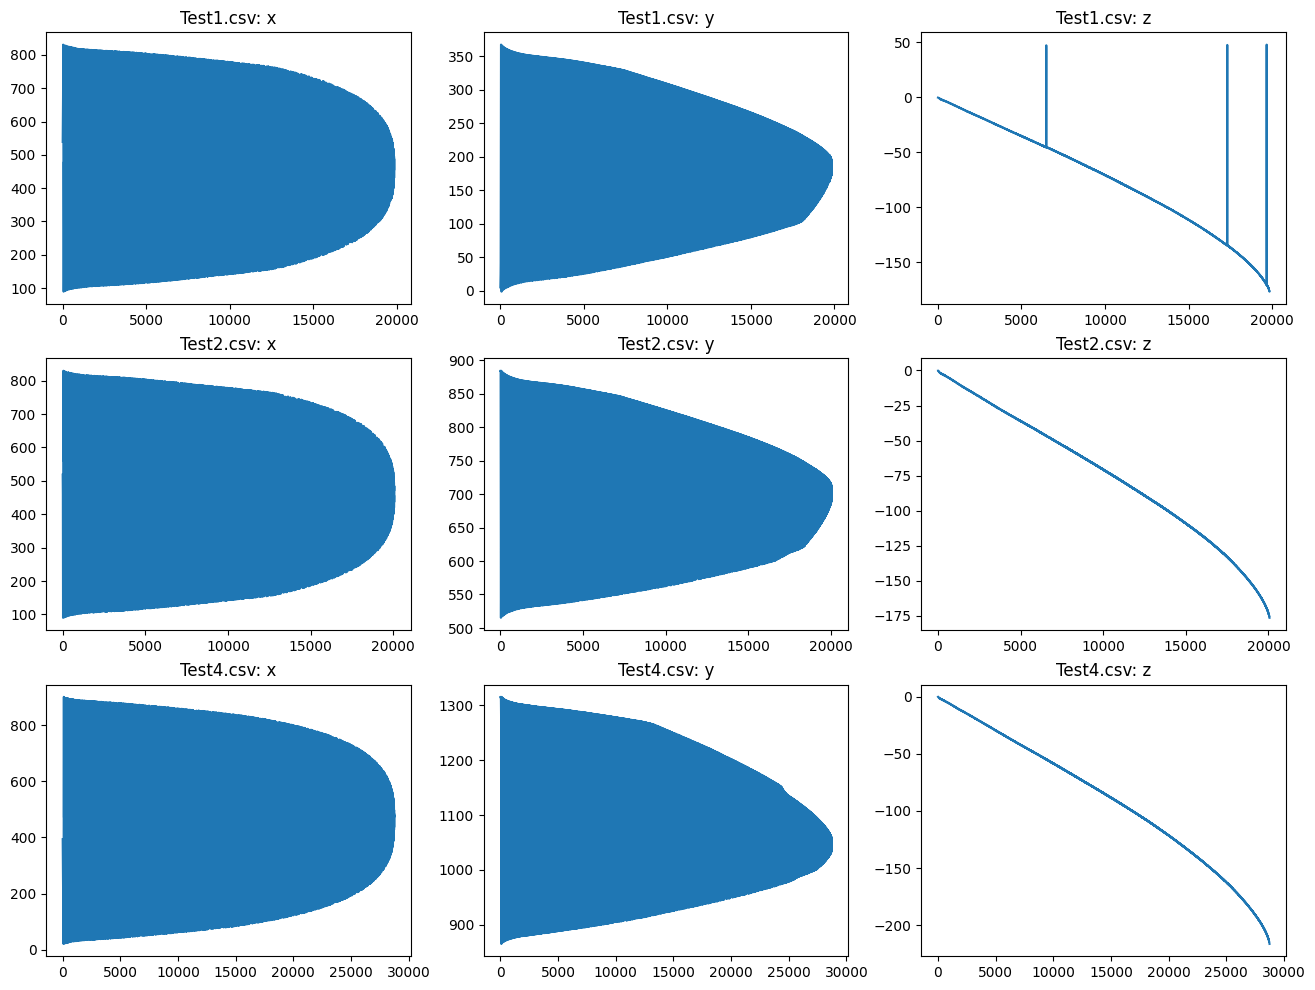

In [15]:
# What does the position trace look like over the whole run?
plot_matrix_summary(keys = ['x', 'y', 'z'], key_template = '{}_enc_1')

# At a high level, the story seems straightforward and the data appears to be pretty clean.
# The arm scans forward in z, slowly, while tracing out an outline in x/y. 
# There are 4 instances where the arm backs off in `z`, smoothly, then re-engages. 
# These show up in the force trace (but you need to zoom in to see it; see below)

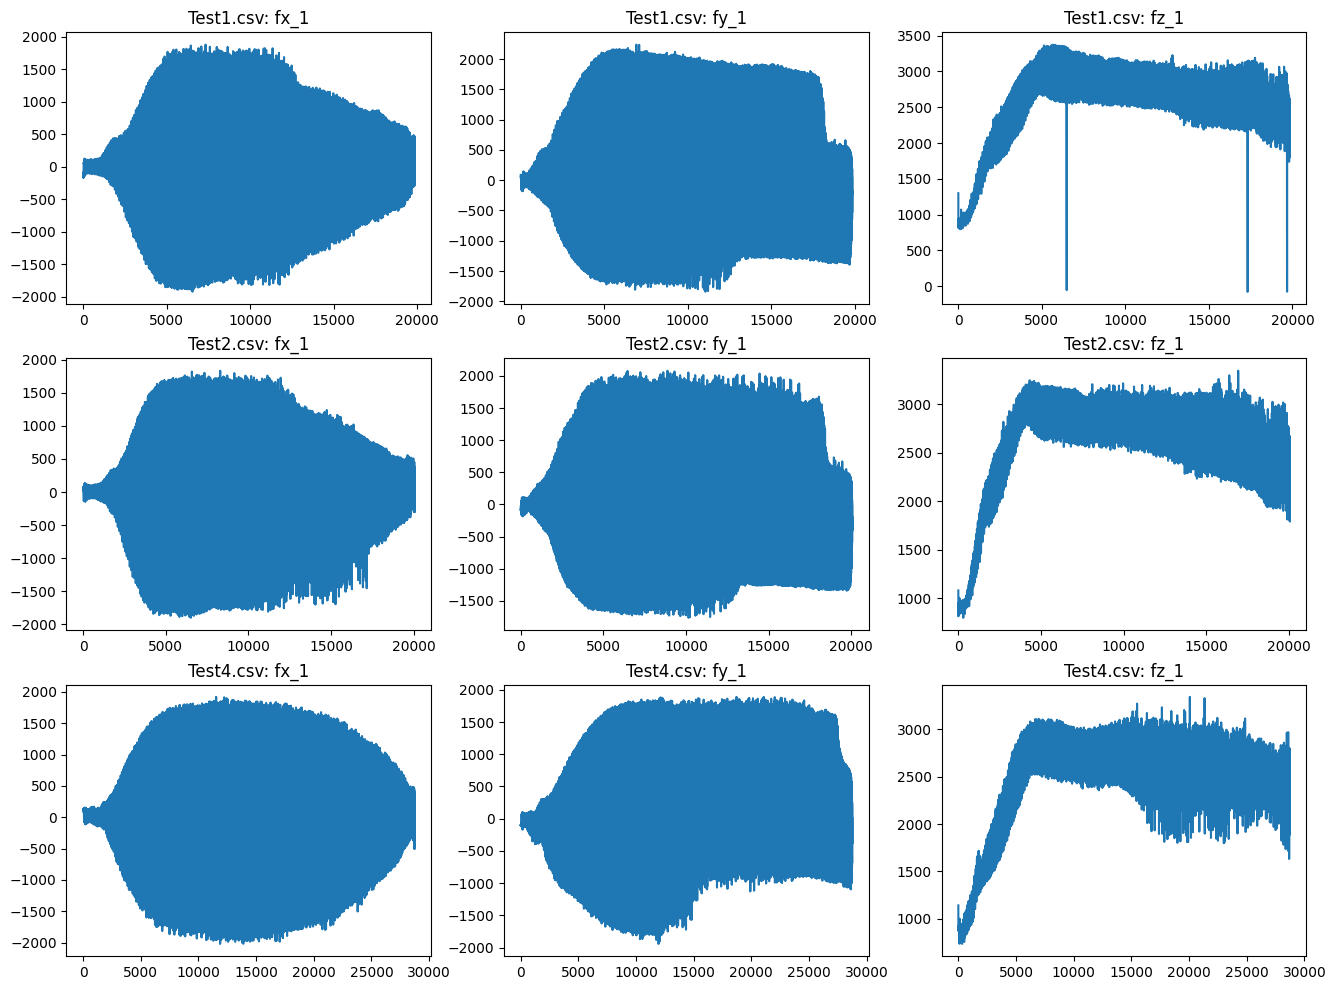

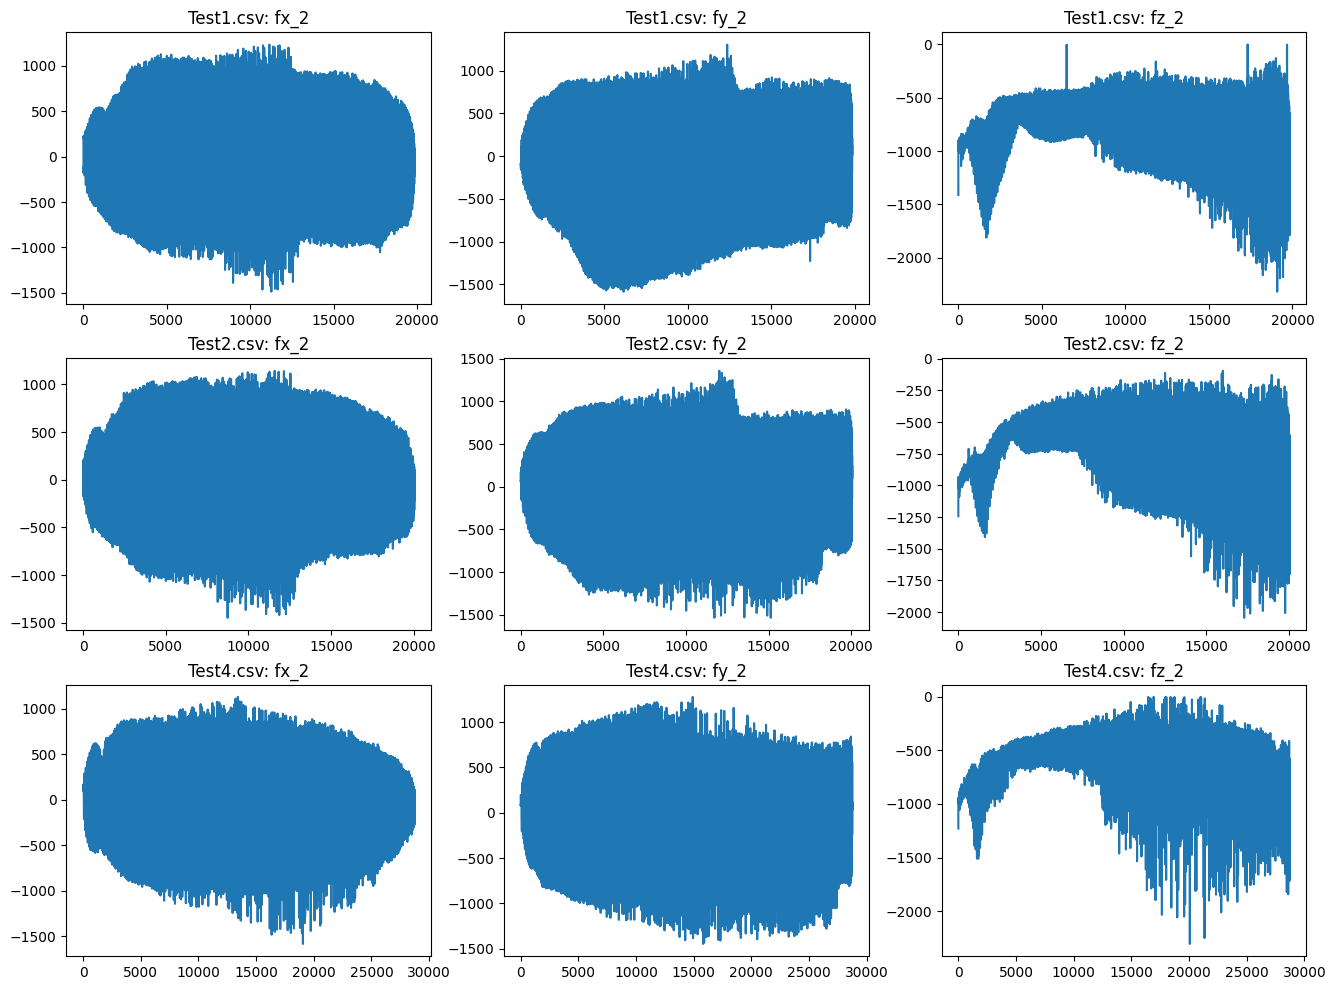

In [16]:
# Check out the forces, again, zoomed out.
plot_matrix_summary(keys = ['fx_1', 'fy_1', 'fz_1'])
plot_matrix_summary(keys = ['fx_2', 'fy_2', 'fz_2'])

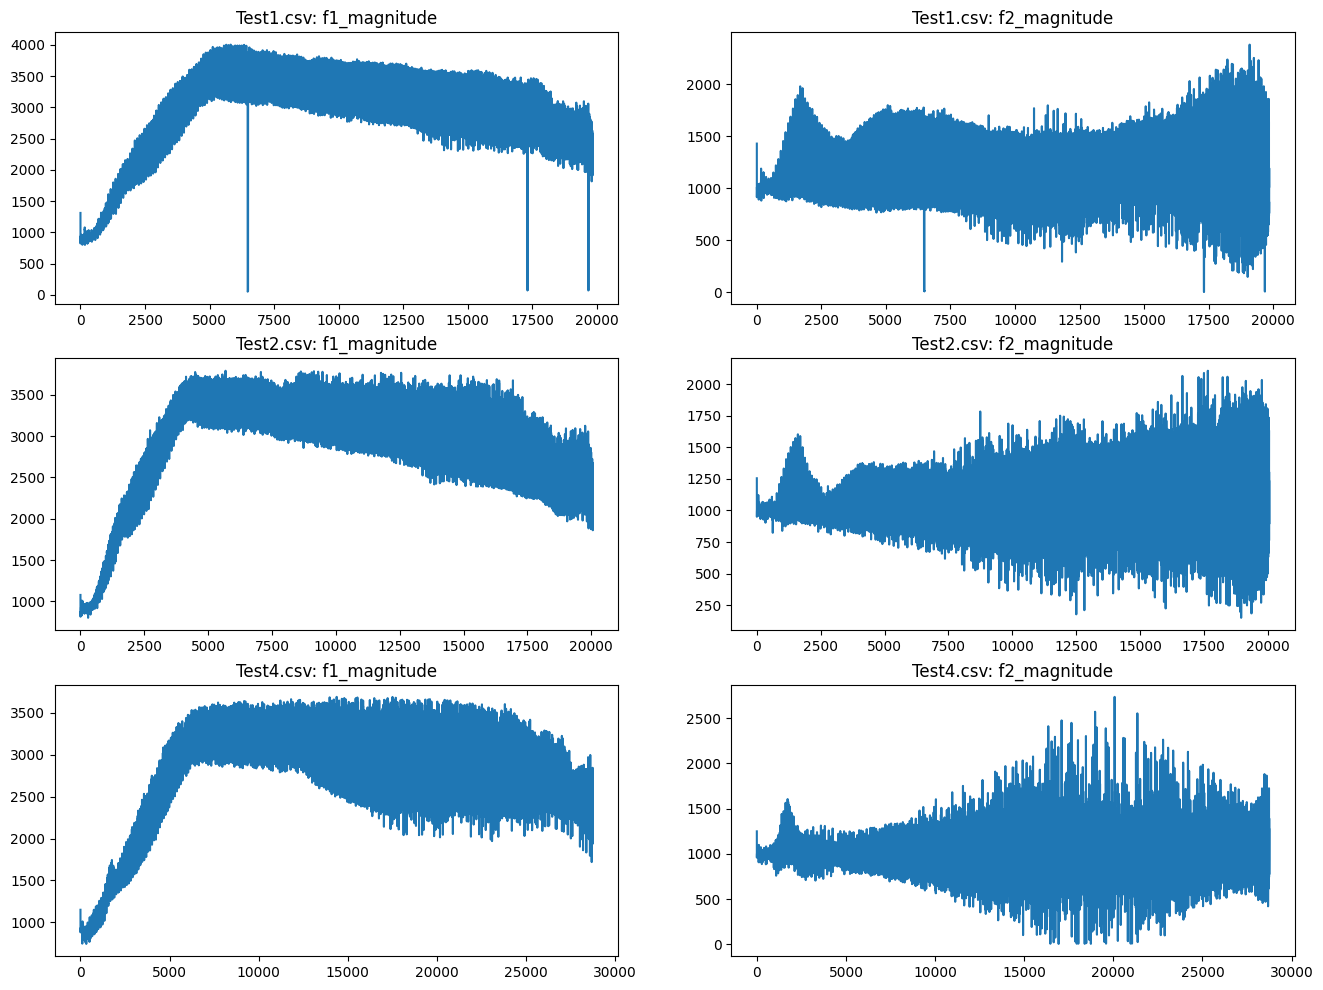

In [17]:
# Plot the overall force vector magnitudes over time to see if there are any macro trends there.
plot_matrix_summary(keys = ["f1_magnitude", "f2_magnitude"])

# Zoom in for high frequency noise / signal structure

We can take a look at the signal closer to the measurement resolution (Hz?) around one of the presumed pull-back events. Honestly, it looks very smooth and the signal appears to be clean.

At this point, I don't see much need for data cleaning - with the exception of finding the start/stop points and potentially filtering out the z-axis pull backs.

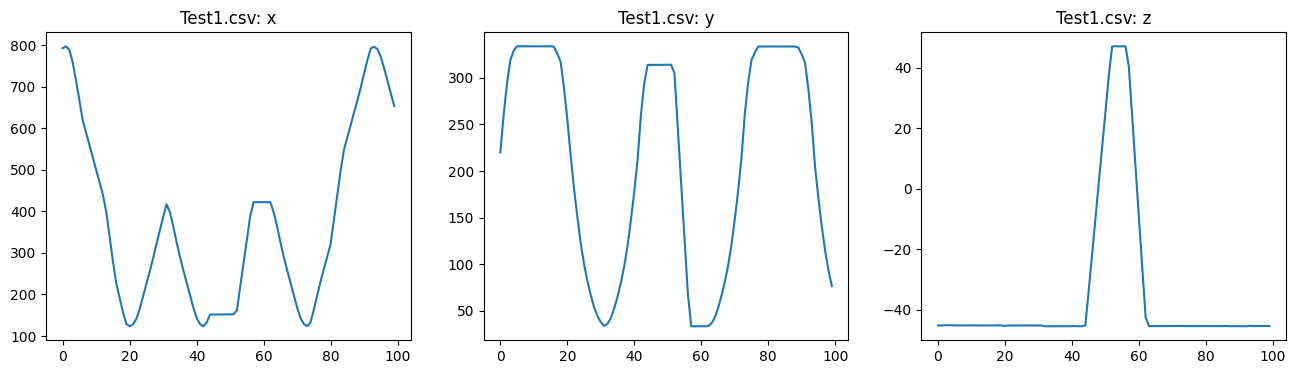

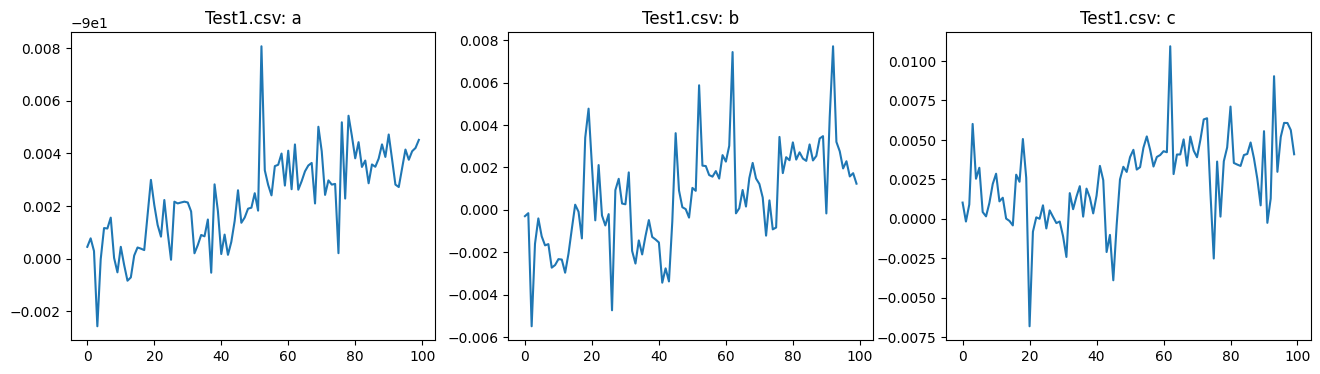

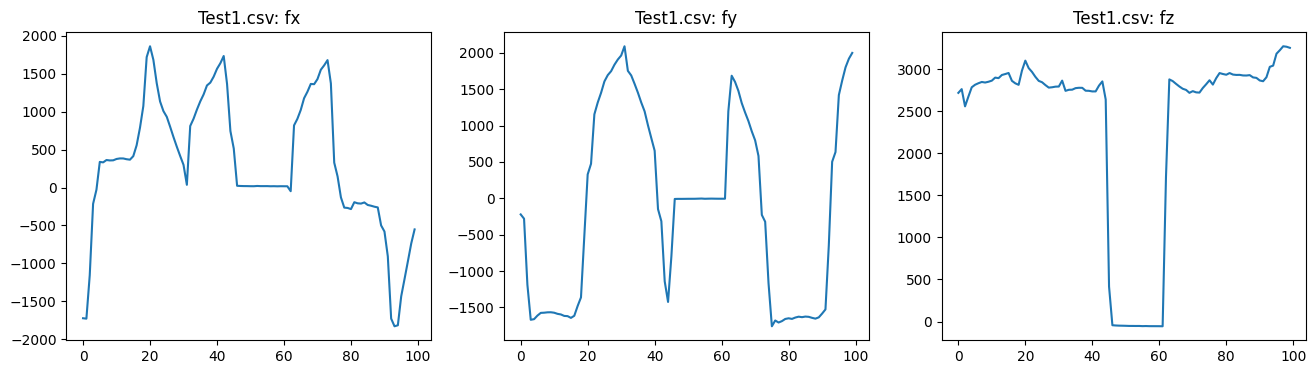

In [18]:
slc = slice(6430, 6530)

# Zoom in to the first time there is a z-axis pull-back just to see how smooth it is, if it looks like an error, etc.
plot_matrix_summary(keys = ['x', 'y', 'z'], key_template = '{}_enc_1', zoom_slice=slc, files=['Test1.csv'])
plot_matrix_summary(keys = ['a', 'b', 'c'], key_template = '{}_enc_1', zoom_slice=slc, files=['Test1.csv'])
plot_matrix_summary(keys = ['fx', 'fy', 'fz'], key_template = '{}_1', zoom_slice=slc, files=['Test1.csv'])

# Take a look at the intermediate / meso-scale

Finally, the meso-scale story also looks pretty reasonable and smooth. The only thing that stands out is R2's "c" (yaw?). Presumably, this is flipping back and forth to oppose sharp features(?). I don't see it obviously in the video, so this is a bit of an unexplained phenomenon to me right now. The frequency of the flips is higher than the force signals, though, so it doesn't seem obviously relevant. Bookmarked for later. 

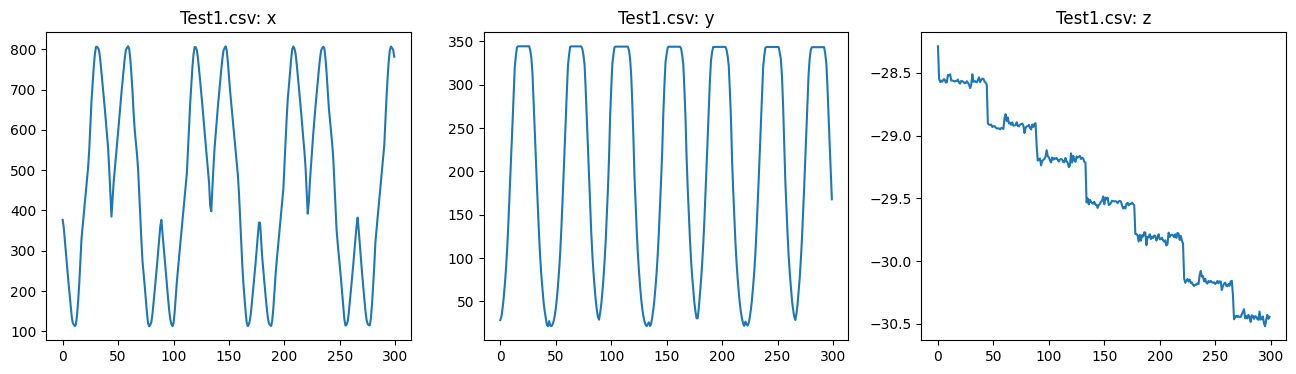

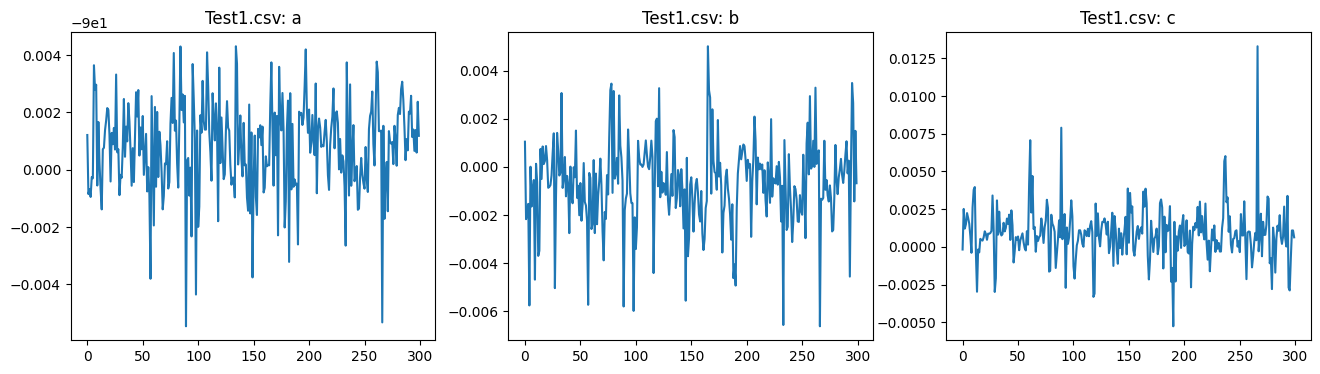

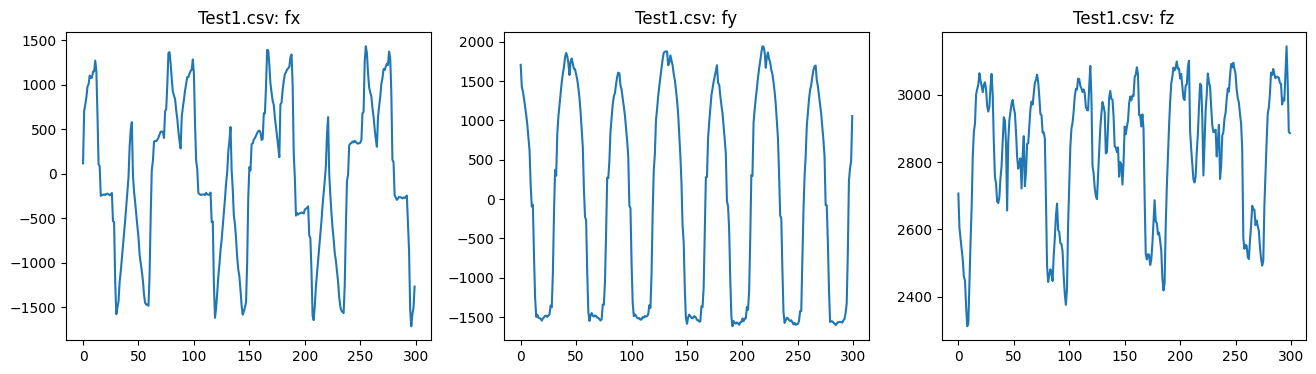

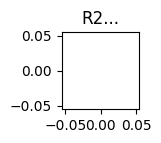

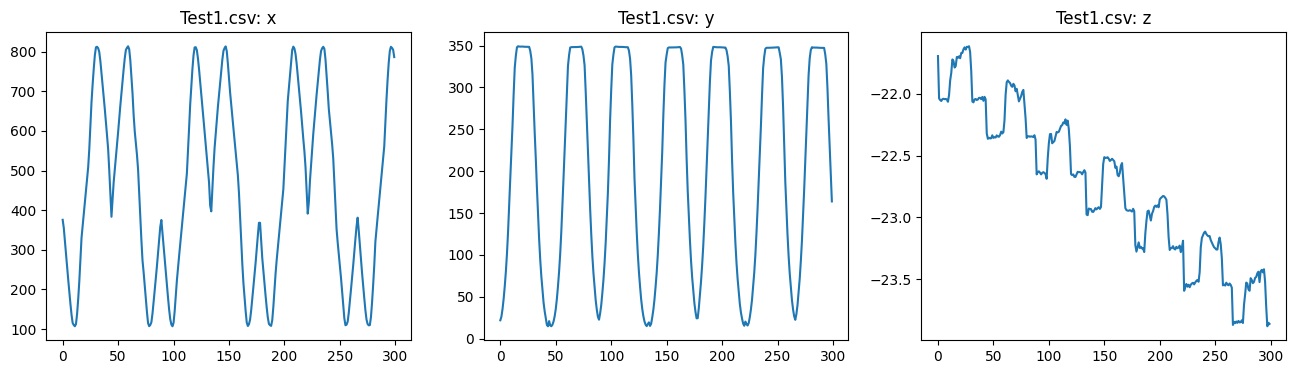

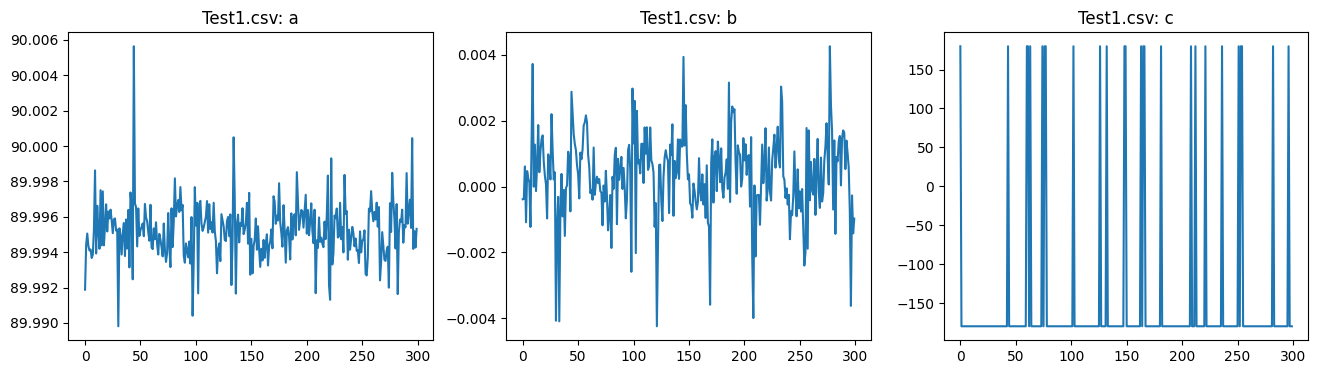

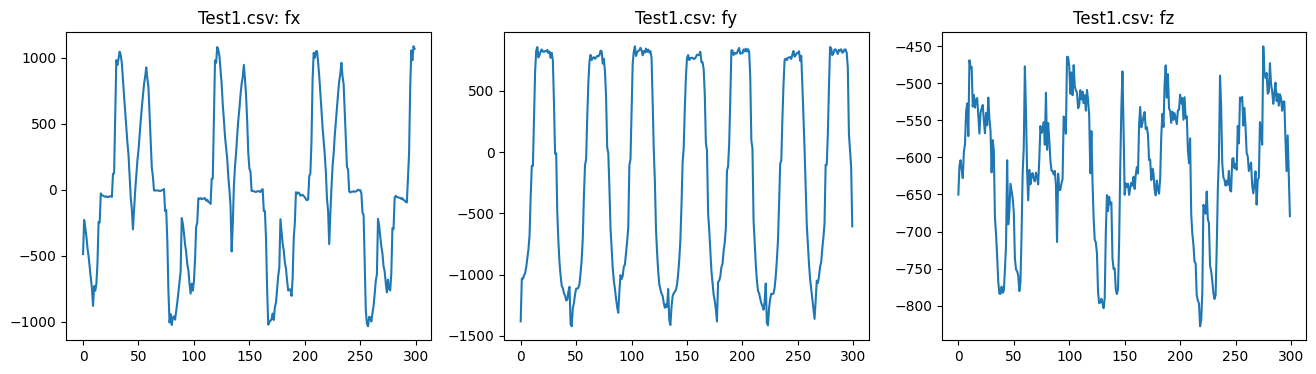

In [19]:
slc = slice(4000, 4300)

plot_matrix_summary(keys = ['x', 'y', 'z'], key_template = '{}_enc_1', zoom_slice=slc, files=['Test1.csv'])
plot_matrix_summary(keys = ['a', 'b', 'c'], key_template = '{}_enc_1', zoom_slice=slc, files=['Test1.csv'])
plot_matrix_summary(keys = ['fx', 'fy', 'fz'], key_template = '{}_1', zoom_slice=slc, files=['Test1.csv'])

# Hack-y separator between the first block of plots (R1) and the second block (R2)
py.figure(figsize=(1,1))
py.title("R2...")
py.plot()

plot_matrix_summary(keys = ['x', 'y', 'z'], key_template = '{}_enc_2', zoom_slice=slc, files=['Test1.csv'])
plot_matrix_summary(keys = ['a', 'b', 'c'], key_template = '{}_enc_2', zoom_slice=slc, files=['Test1.csv'])
plot_matrix_summary(keys = ['fx', 'fy', 'fz'], key_template = '{}_2', zoom_slice=slc, files=['Test1.csv'])

# Take a 3D look at the space-curves R1 and R2 trace over a few time slices

Before summarizing, let's just look at a quick trace through time of R1 and R2. z-forces dominate in terms of scale and matplotlib struggles with that, so just show xy forces. 

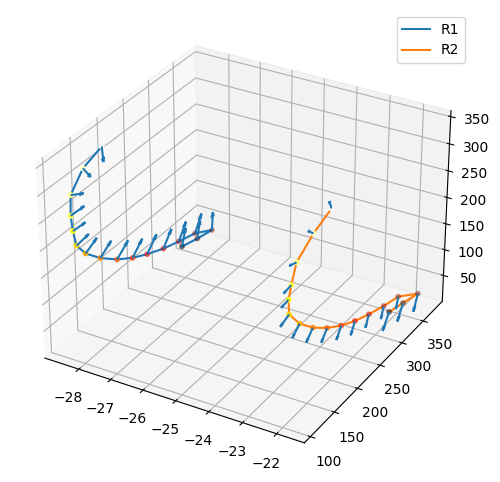

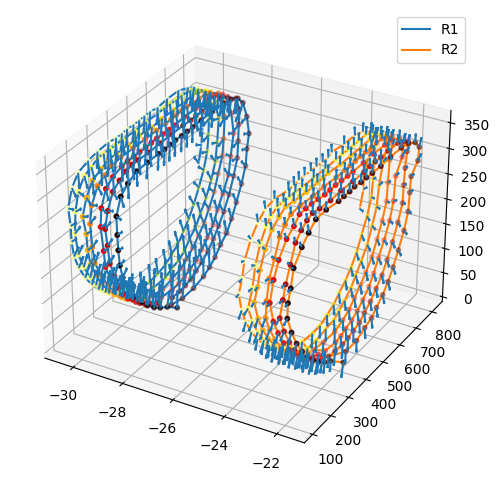

In [20]:
def plot_3d_point_dynamics(slc, csv_fname):
    from matplotlib import cm

    py.figure(figsize=(12, 6))
    ax = py.subplot(projection='3d')
    
    for R_idx in [1, 2]:
        # Prepare arrays x, y, z
        df = load(csv_fname)
        
        t = df["t"].to_numpy()[slc]      
        t = 1.0 * t - t[0]
        t = t / t.max()
        
        x = df["x_enc_{}".format(R_idx)].to_numpy()[slc]
        y = df["y_enc_{}".format(R_idx)].to_numpy()[slc]
        z = df["z_enc_{}".format(R_idx)].to_numpy()[slc]
        
        force_scale = 0.02
        # z-forces dominate, so leave them out.
        fz = (df["fz_{}".format(R_idx)].to_numpy()[slc]) * 0.0
        
        # scale down forces to view them more easily in the viewport (scale is arb.)
        force_scale = 0.02
        fx = (df["fx_{}".format(R_idx)].to_numpy()[slc]) * force_scale
        fy = (df["fy_{}".format(R_idx)].to_numpy()[slc]) * force_scale
        
        ax.plot(z, x, y, label='R{}'.format(R_idx))
        ax.scatter(z, x, y, color=cm.hot(t), s = 10)
        ax.legend()
        
        ax.quiver(z, x, y, fz, fx, fy, normalize=False)

    py.show()
    
slc = slice(3998, 4015)
plot_3d_point_dynamics(slc, "Test1.csv")

slc = slice(4000, 4300)
plot_3d_point_dynamics(slc, "Test1.csv")

Sweep looks smooth, clean, no big oddities here. If you make these plots interactive, you can see R2 pull back a bit and let R1 deform the plate, which is neat but ~expected. Unclear if this insight will effect modeling at this point. Again, bookmarked for later.

# Overall summary

Honestly, not a lot of surprises from the data here. The orientation of the head seems, at this point, not obviously a big part of the story, but otherwise the forces vary ~smoothly and intuitively based on the trace (x,y). 

In terms of modeling, the signal that seems the hardest to capture (a priori) is the fact that the *magnitude* of the force vector on R1 steadily increases over a fairly long timescale compared to the signal the model actually has (position/orientation). Put simply, the force required to deform comparable dz at t=4000 is much larger than at t=500. Why?

Work hardening is a thing,although I don't know that it should be this large a factor (2-3x increase). It could be that the "pinch" is simply tighter later on because you are forming tighter features. Capturing this trend faithfully without just learning a fudge factor from the build time (risky, won't generalize well). This trend may be impossible to capture in a meaningful, general way with the signals we have at hand here. 

As a prior, I'm going to start with features related to the displacement between the R1 and R2 to approximate the deformation being attempted and add the time-derivative features you would expect to contain most of the stress information (the strain ~= dx/dt).